# Actually computing Fourier transforms in Python

Fourier transforms are among the most useful tools employed by physicists, mathematicians, engineers and computer scientists. As a physicist, I've often wanted to calculate Fourier transforms (and their inverses) for a various functions - but this is not easily done on paper.

Computationally, the [fast Fourier transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) made it easy to calculate Fourier transforms of discrete signals, but I hadn't seen ways to calculate the Fourier transform of **continuous** functions, as we often do in Physics.

My goal with this article is to describe how it can be done, and show a Python implementation.

# Definitions

We use the following definitions ("physicist's convention") for the Fourier transform and its inverse.

Let $f: \mathbf{R} \to \mathbf{C}$ be a complex-valued function which is both integrable and square-integrable. Then its Fourier transform, denoted as $\hat f$ or $\mathcal F[f]$, is the complex-valued function given by

$$\hat f(k) := \int_{-\infty}^\infty dx \; e^{-ikx} f(x)\tag{1}$$

Similarly, for a complex-valued function $\hat g$, we define its inverse Fourier transform (denoted as $g$ or $\mathcal F^{-1}[\hat g]$) as

$$g(x) := \int_{-\infty}^\infty \frac{dk}{2\pi}\; e^{ikx} \hat g(k)\tag{2}$$

## Connecting the Fourier transform and the Discrete Fourier transform (DFT)

Numerically calculating these integrals can be done, but is often intractable - this is especially true in higher dimensions. Therefore, some choice of discretization must be employed.

As written in the Numpy [documentation for Fourier transforms](https://numpy.org/doc/stable/reference/routines.fft.html), the key to do that is the discrete Fourier transform (DFT):

> When both the function and its Fourier transform are replaced with discretized counterparts, it is called the discrete Fourier transform (DFT). The DFT has become a mainstay of numerical computing in part because of a very fast algorithm for computing it, called the Fast Fourier Transform (FFT), which was known to Gauss (1805) and was brought to light in its current form by Cooley and Tukey.

According to the same documentation, the DFT of a sequence $a_0,\ldots, a_{n-1}$ with $n$ elements is calculated as

$$\hat a_l = \sum_{m=0}^{n-1} a_m \exp \left( - 2\pi i\frac{ml}{n}\right),\quad l = 0,\ldots, n-1.\tag{3}$$

Can we bring Eq. (1) to this form?

First, we break down the integral into a Riemann sum. We will sample $x$ at $n$ distinct and evenly spaced points $x_m = x_0 + m \Delta x$, where $m$ ranges from 0 to $n-1$ and $x_0$ is an arbitrarily chosen leftmost point. Then, we can approximate the integral as

$$\begin{align*}
\hat f(k) &\approx \sum_{m=0}^{n-1} \Delta x\; e^{-ik x_m} f(x_m)\\
&= \sum_{m=0}^{n-1} \Delta x \; e^{-ikx_0 - ik m\Delta x} f(x_m)\\
&= \Delta x \; e^{-ikx_0} \sum_{m=0}^{n-1} e^{- ik m\Delta x} f(x_m)
\end{align*}$$

Not, we must similarly discretize the variable $k$: let us sample it at $n$ evenly-spaced points $k_l = l \Delta k$. Then the integral becomes

$$\hat f(k_l) = \Delta x \; e^{-ik_l x_0} \sum_{m=0}^{n-1} \exp\left(- i m l\Delta k \Delta x\right) f(x_m)$$


This is almost in the form specified by Numpy, Eq. (3); a final touch is to relate $\Delta x$ and $\Delta k$ so that the exponent term becomes $-2\pi i ml/n$:

$$\Delta x\Delta k = \frac{2\pi}{n}$$

which a few of you might recognize as the [uncertainty principle](https://en.wikipedia.org/wiki/Fourier_transform#Uncertainty_principle). 

Therefore, we get our final equation

$$\hat f(k_l) = \Delta x \; e^{-i k_l x_0} \mathrm{DFT}[\{f(x_m\}],\quad \Delta x \Delta k = \frac{2\pi}{n},\quad x_m = x_0 + m\Delta x, k_l = l \Delta k$$

We can do the same for the inverse transform. In Numpy, it is defined as

$$a_m = \frac{1}{n} \sum_{l=0}^{n-1} A_l \exp \left(2\pi i \frac{ml}{n} \right)$$

Note the normalizing factor of $1/n$.

Then, we proceed exactly as before:

$$\begin{align*}
f(x) &= \int \frac{dk}{2\pi} \; e^{ikx} \hat f(k)\\
f(x_m) &\approx \sum_{l=0}^{n-1} \frac{\Delta k}{2\pi}\; \exp \left( i lm \Delta k \Delta x \right) \hat f(k_l)\\
&= \frac{n \Delta k}{2\pi}\cdot \frac{1}{n} \sum_{l=0}^{n-1} \exp \left(2\pi i \frac{ml}{n} \right) \hat f(k_l)\\
&= \frac{n \Delta k}{2\pi} \mathrm{IDFT}[\{\hat f(k_l) \}]
\end{align*}$$

Below, we show these implementations in Python as well as examples for a few known Fourier transform pairs.

# Implementation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


def fourier_transform_1d(func, x, sort_results=False):

    """
    Computes the continuous Fourier transform of function `func`, following the physicist's convention
    Grid x must be evenly spaced.

    Parameters
    ----------

    - func (callable): function of one argument to be Fourier transformed
    - x (numpy array) evenly spaced points to sample the function
    - sort_results (bool): reorders the final results so that the x-axis vector is sorted in a natural order.
        Warning: setting it to True makes the output not transformable back via Inverse Fourier transform

    Returns
    --------
    - k (numpy array): evenly spaced x-axis on Fourier domain. Not sorted from low to high, unless `sort_results` is set to True
    - g (numpy array): Fourier transform values calculated at coordinate k
    """
    x0, dx = x[0], x[1] - x[0]
    f = func(x)
    
    g = np.fft.fft(f) # DFT calculation

    # frequency normalization factor is 2*np.pi/dt
    w = np.fft.fftfreq(f.size)*2*np.pi/dx

    # Multiply by external factor
    g *= dx*np.exp(-complex(0,1)*w*x0) 
    
    if sort_results:    
        zipped_lists = zip(w, g)
        sorted_pairs = sorted(zipped_lists)
        sorted_list1, sorted_list2 = zip(*sorted_pairs)
        w = np.array(list(sorted_list1))
        g = np.array(list(sorted_list2))
        
    return w, g


def inverse_fourier_transform_1d(func, k, sort_results=False):
    """
    Computes the inverse Fourier transform of function `func`, following the physicist's convention
    Grid x must be evenly spaced.

    Parameters
    ----------

    - func (callable): function of one argument to be inverse Fourier transformed
    - k (numpy array) evenly spaced points in Fourier space to sample the function
    - sort_results (bool): reorders the final results so that the x-axis vector is sorted in a natural order.
        Warning: setting it to True makes the output not transformable back via Fourier transform

    Returns
    --------
    - y (numpy array): evenly spaced x-axis. Not sorted from low to high, unless `sort_results` is set to True
    - h (numpy array): inverse Fourier transform values calculated at coordinate x
    """
    dk = k[1] - k[0]
    
    f = np.fft.ifft(func) * len(k) * dk /(2*np.pi)
    x = np.fft.fftfreq(f.size)*2*np.pi/dk

    if sort_results:    
        zipped_lists = zip(x, f)
        sorted_pairs = sorted(zipped_lists)
        sorted_list1, sorted_list2 = zip(*sorted_pairs)
        x = np.array(list(sorted_list1))
        f = np.array(list(sorted_list2))
    return x, f


# Examples

We a first example, we consider the step function 

$$f(x) = 1_{-1/2 < x < 1/2}$$, i.e. a function which is 1 between -1/2 and 1/2, and zero elsewhere. Its Fourier transform is

$$\hat f(k) = \mathrm{sinc}(k/2),\quad \mathrm{where}\; \mathrm{sinc}(x) \equiv \sin(x)/x$$

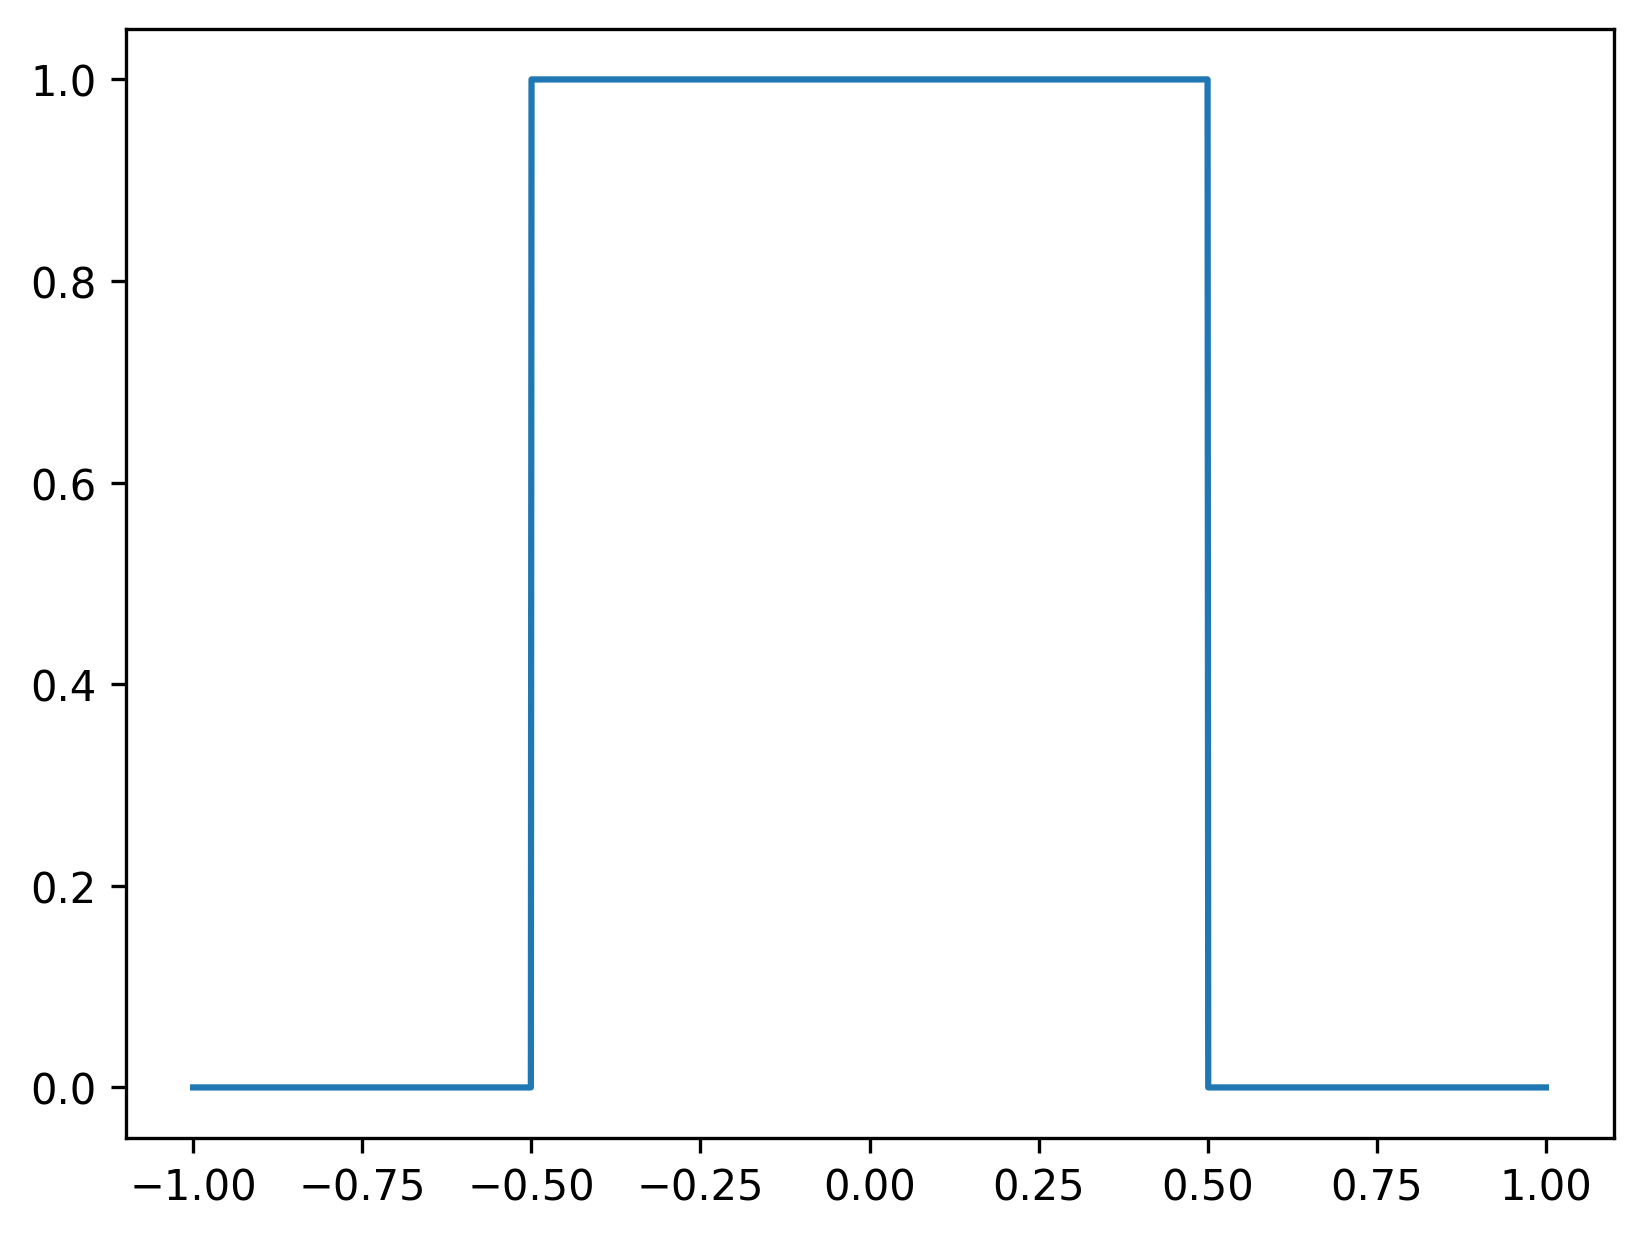

In [3]:
N = 2048

# Define the function f(x)
f = lambda x: np.where((x >= -0.5) & (x <= 0.5), 1, 0)
x = np.linspace(-1, 1, N) 
plt.plot(x, f(x));

/var/folders/74/9pmszzb927x5lg1pptjtnww00000gn/T/ipykernel_6210/2540568565.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(k, np.sin(k/2)/(k/2), linestyle='-.', label='Analytic (samples)')


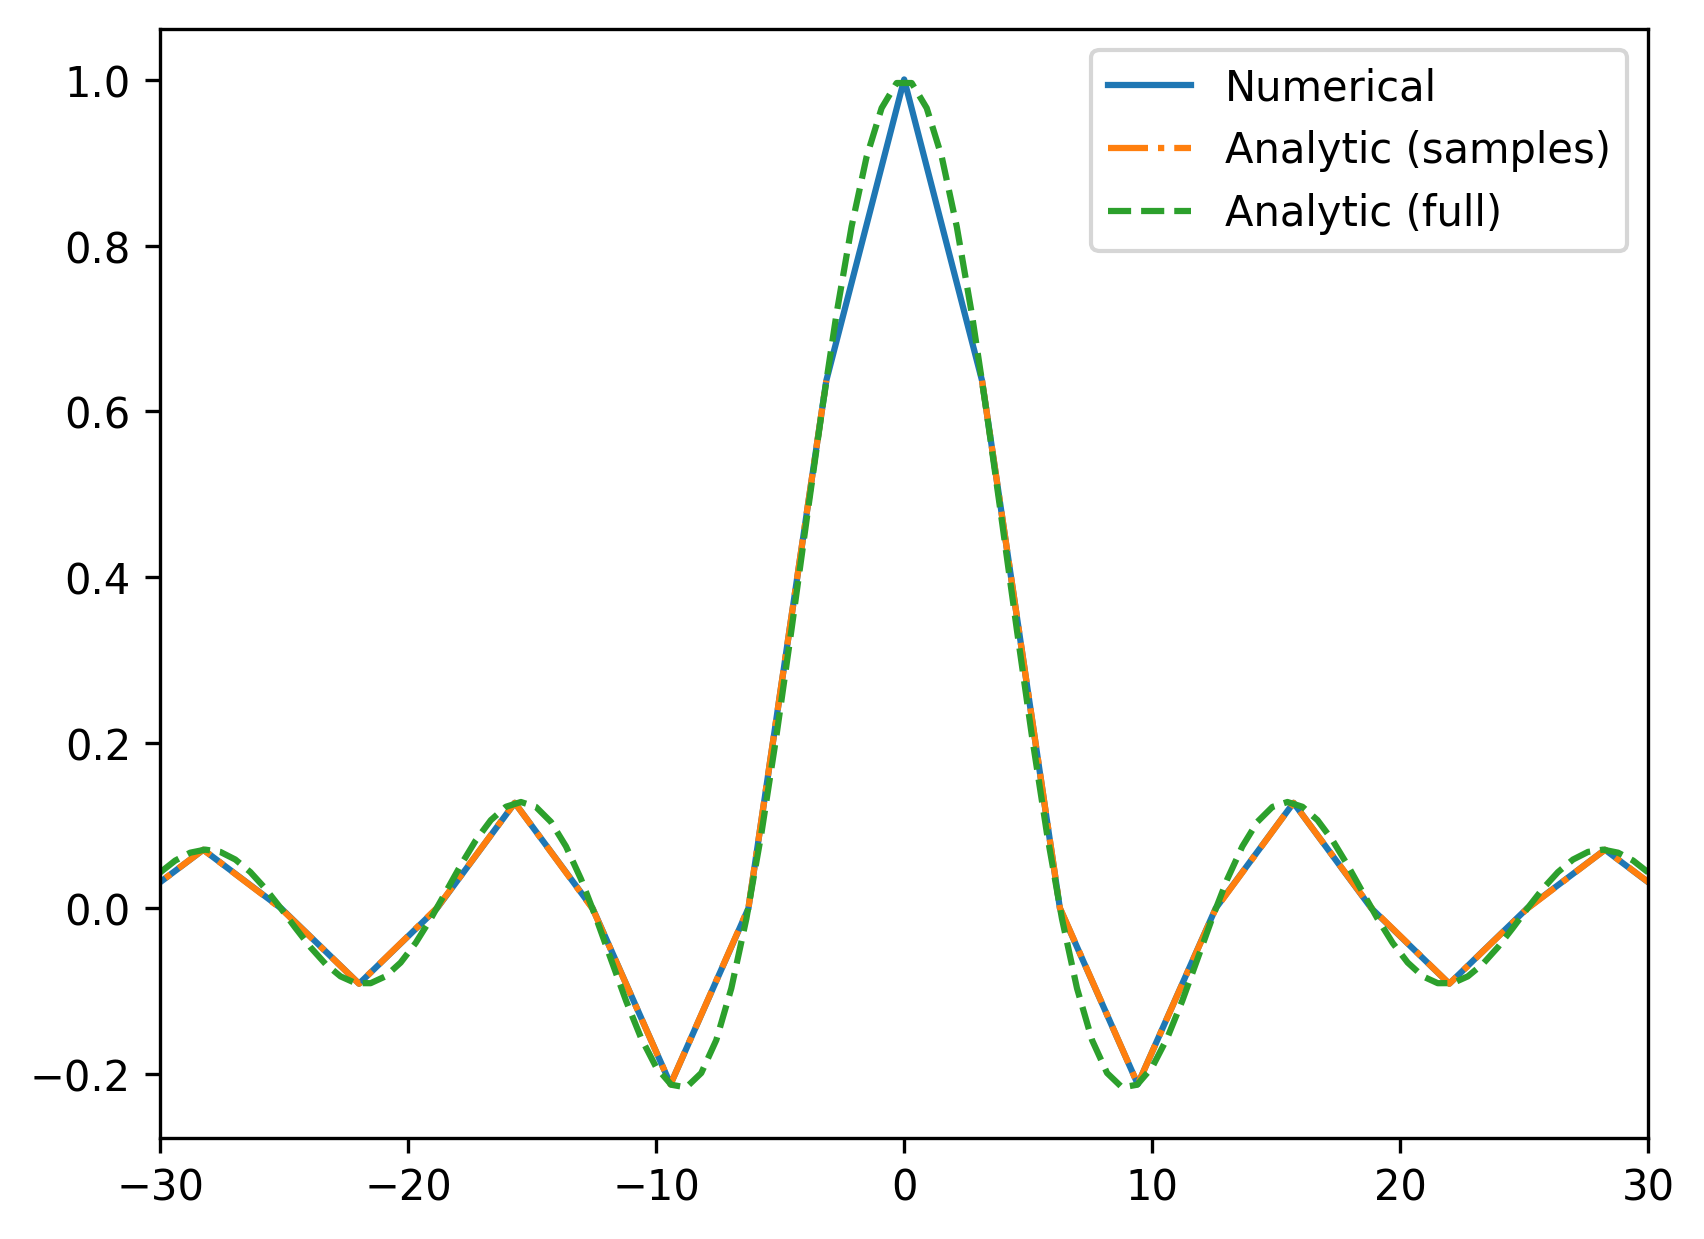

In [4]:
k, g = fourier_transform_1d(f, x, sort_results=True) # make it easier to plot
kk = np.linspace(-30,30, 100)

plt.plot(k, np.real(g), label='Numerical'); 
plt.plot(k, np.sin(k/2)/(k/2), linestyle='-.', label='Analytic (samples)')
plt.plot(kk, np.sin(kk/2)/(kk/2), linestyle='--', label='Analytic (full)')
plt.xlim(-30, 30)
plt.legend();

Now, let's check the inverse Fourier transform:

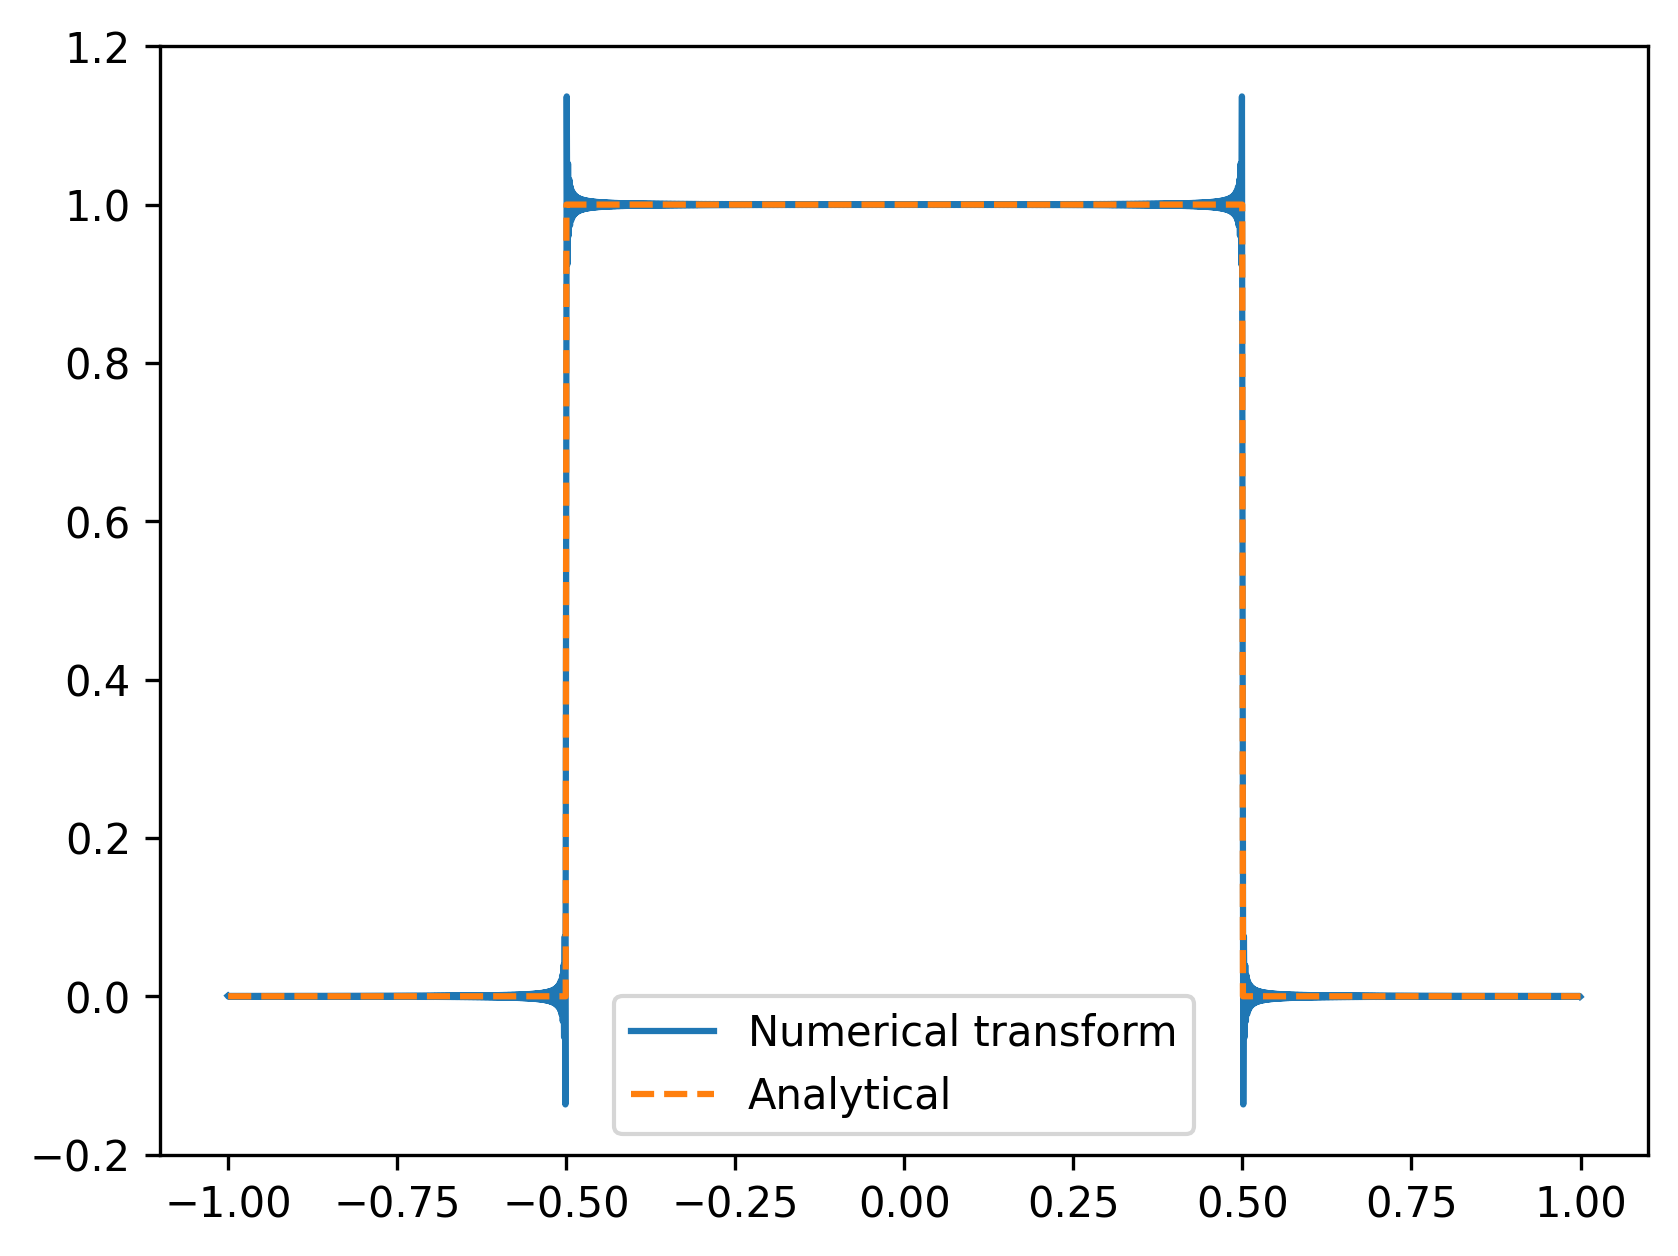

In [5]:
k, g = fourier_transform_1d(f, x)
y, h = inverse_fourier_transform_1d(g, k, sort_results=True)

plt.plot(y, np.real(h), label='Numerical transform')
plt.plot(x, f(x), linestyle='--', label='Analytical')
plt.legend();

We see clearly the [Gibbs phenomenon](https://en.wikipedia.org/wiki/Gibbs_phenomenon) at the discontinuous edges. 

As a second example, we consider the [Gaussian PDF](https://en.wikipedia.org/wiki/Normal_distribution)

$$f(x) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(- \frac{(x-\mu)^2}{2a^2} \right)$$

with Fourier transform

$$\hat f(k) = \exp \left(-\mu k + \frac{\sigma^2 k^2}{2} \right)$$

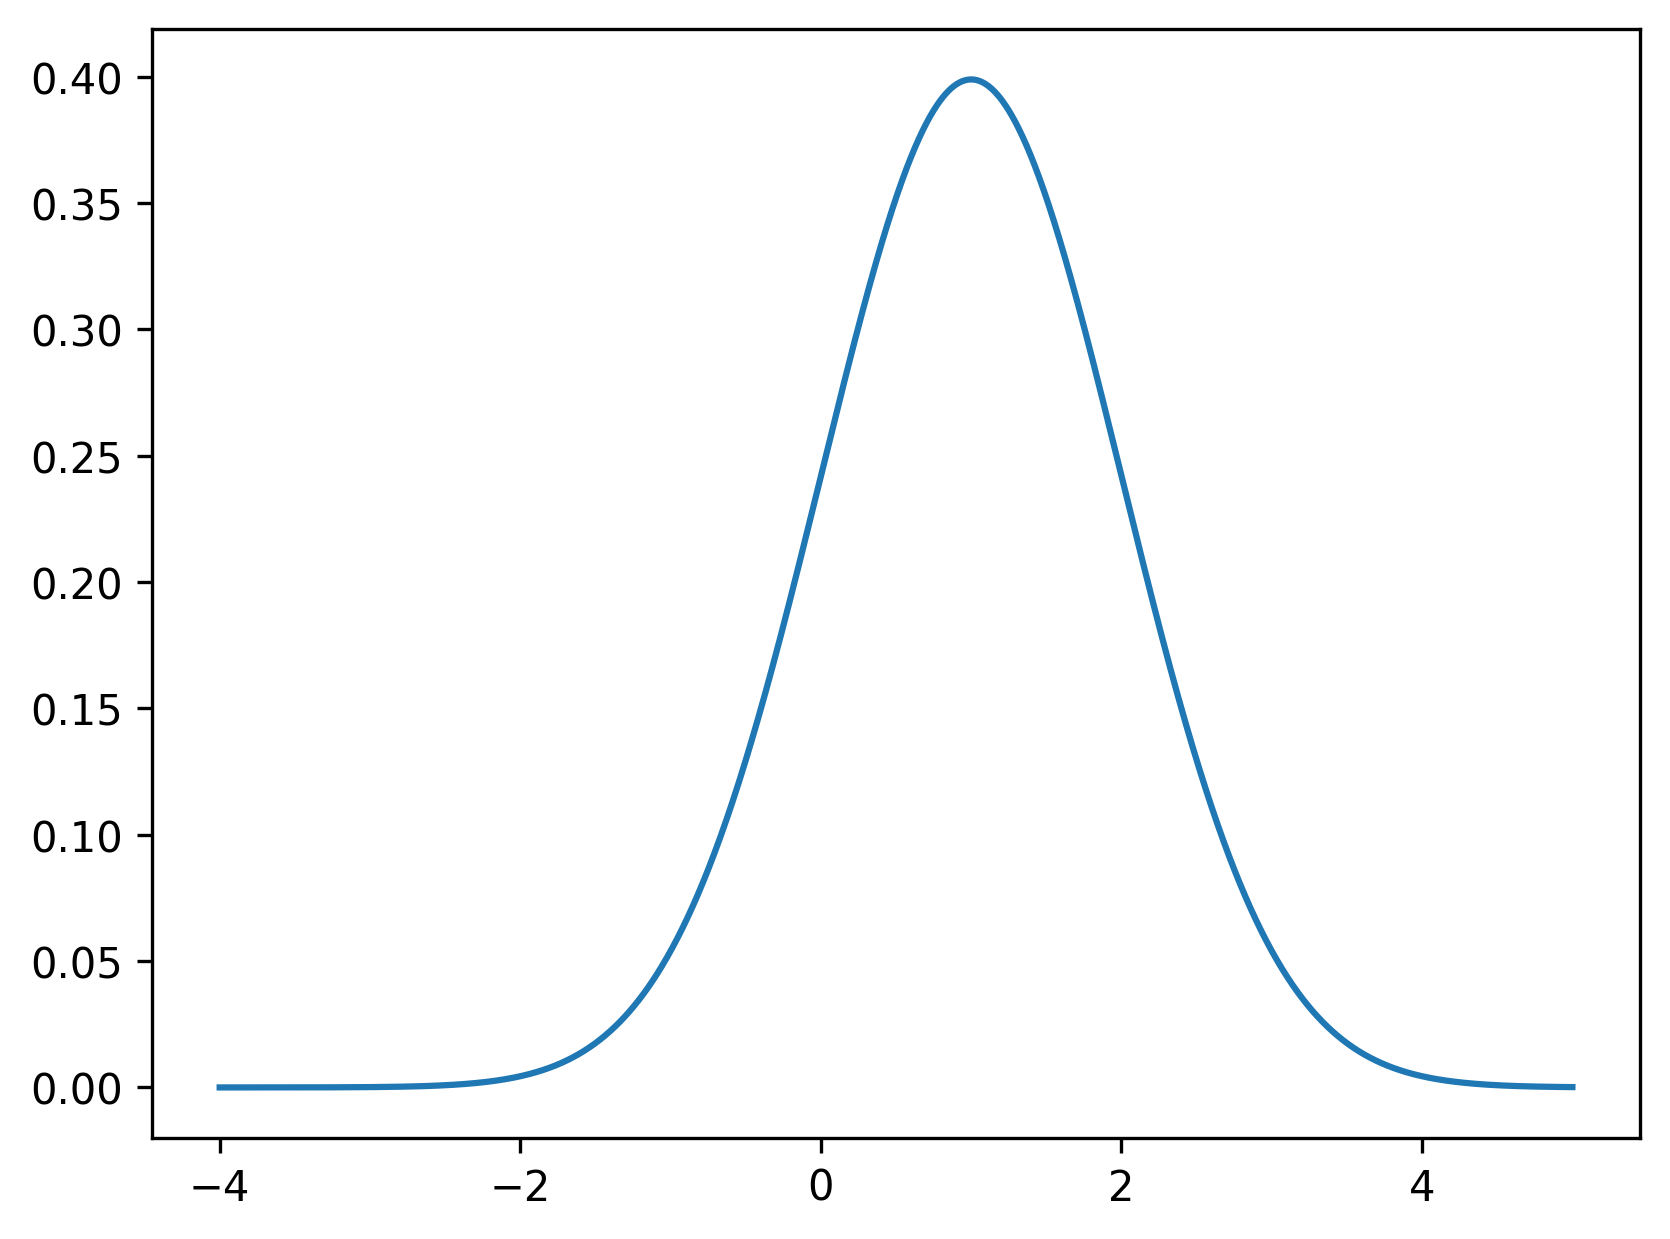

In [6]:
from scipy.stats import norm
from functools import partial

N = 2048
f = partial(norm.pdf, loc=1, scale=1)
x = np.linspace(-4, 5, N) 
plt.plot(x, f(x));

/Users/alessandro/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/alessandro/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


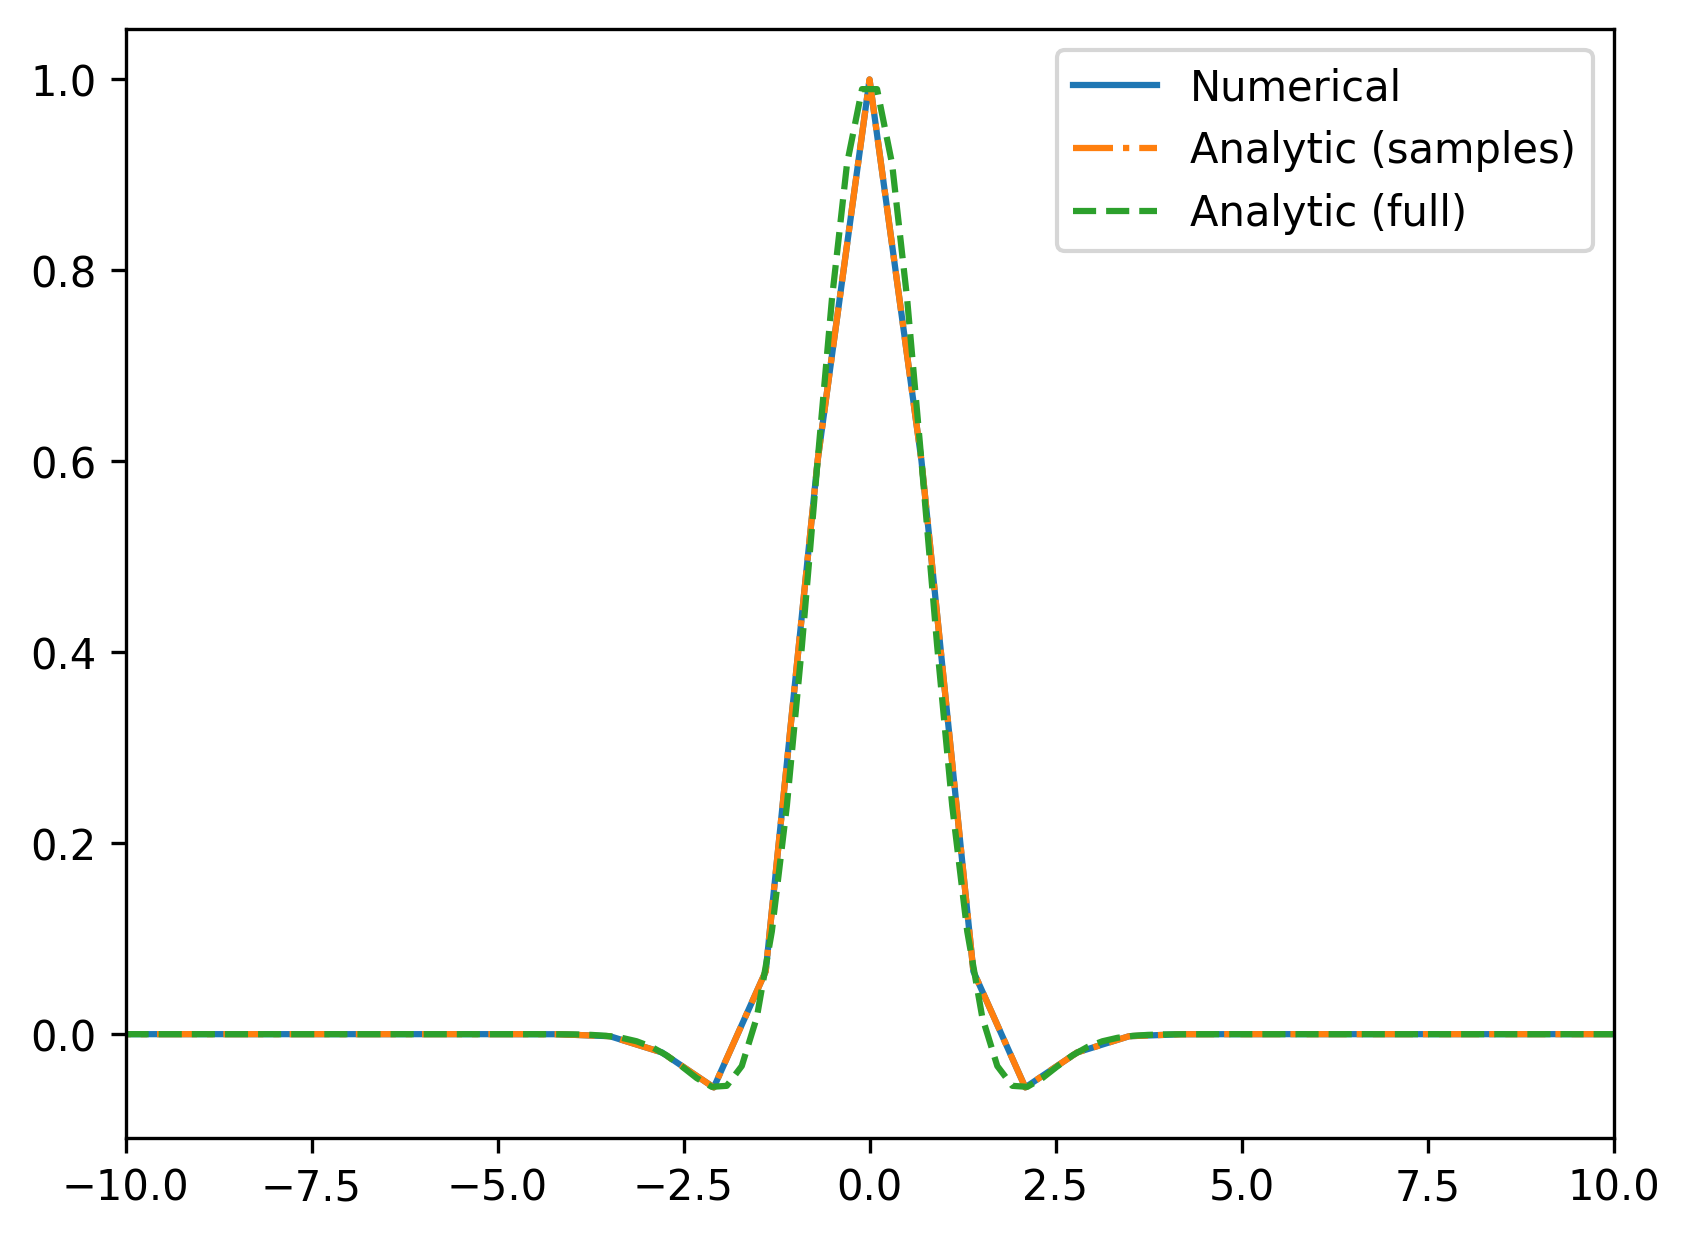

In [7]:
k, g = fourier_transform_1d(f, x, sort_results=True) # make it easier to plot
kk = np.linspace(-10,10, 100)

plt.plot(k, np.real(g), label='Numerical'); 
plt.plot(k, np.exp(-complex(0,1)*k - k**2/2), linestyle='-.', label='Analytic (samples)')
plt.plot(kk, np.exp(-complex(0,1)*kk - kk**2/2), linestyle='--', label='Analytic (full)')
plt.xlim(-10, 10)
plt.legend();

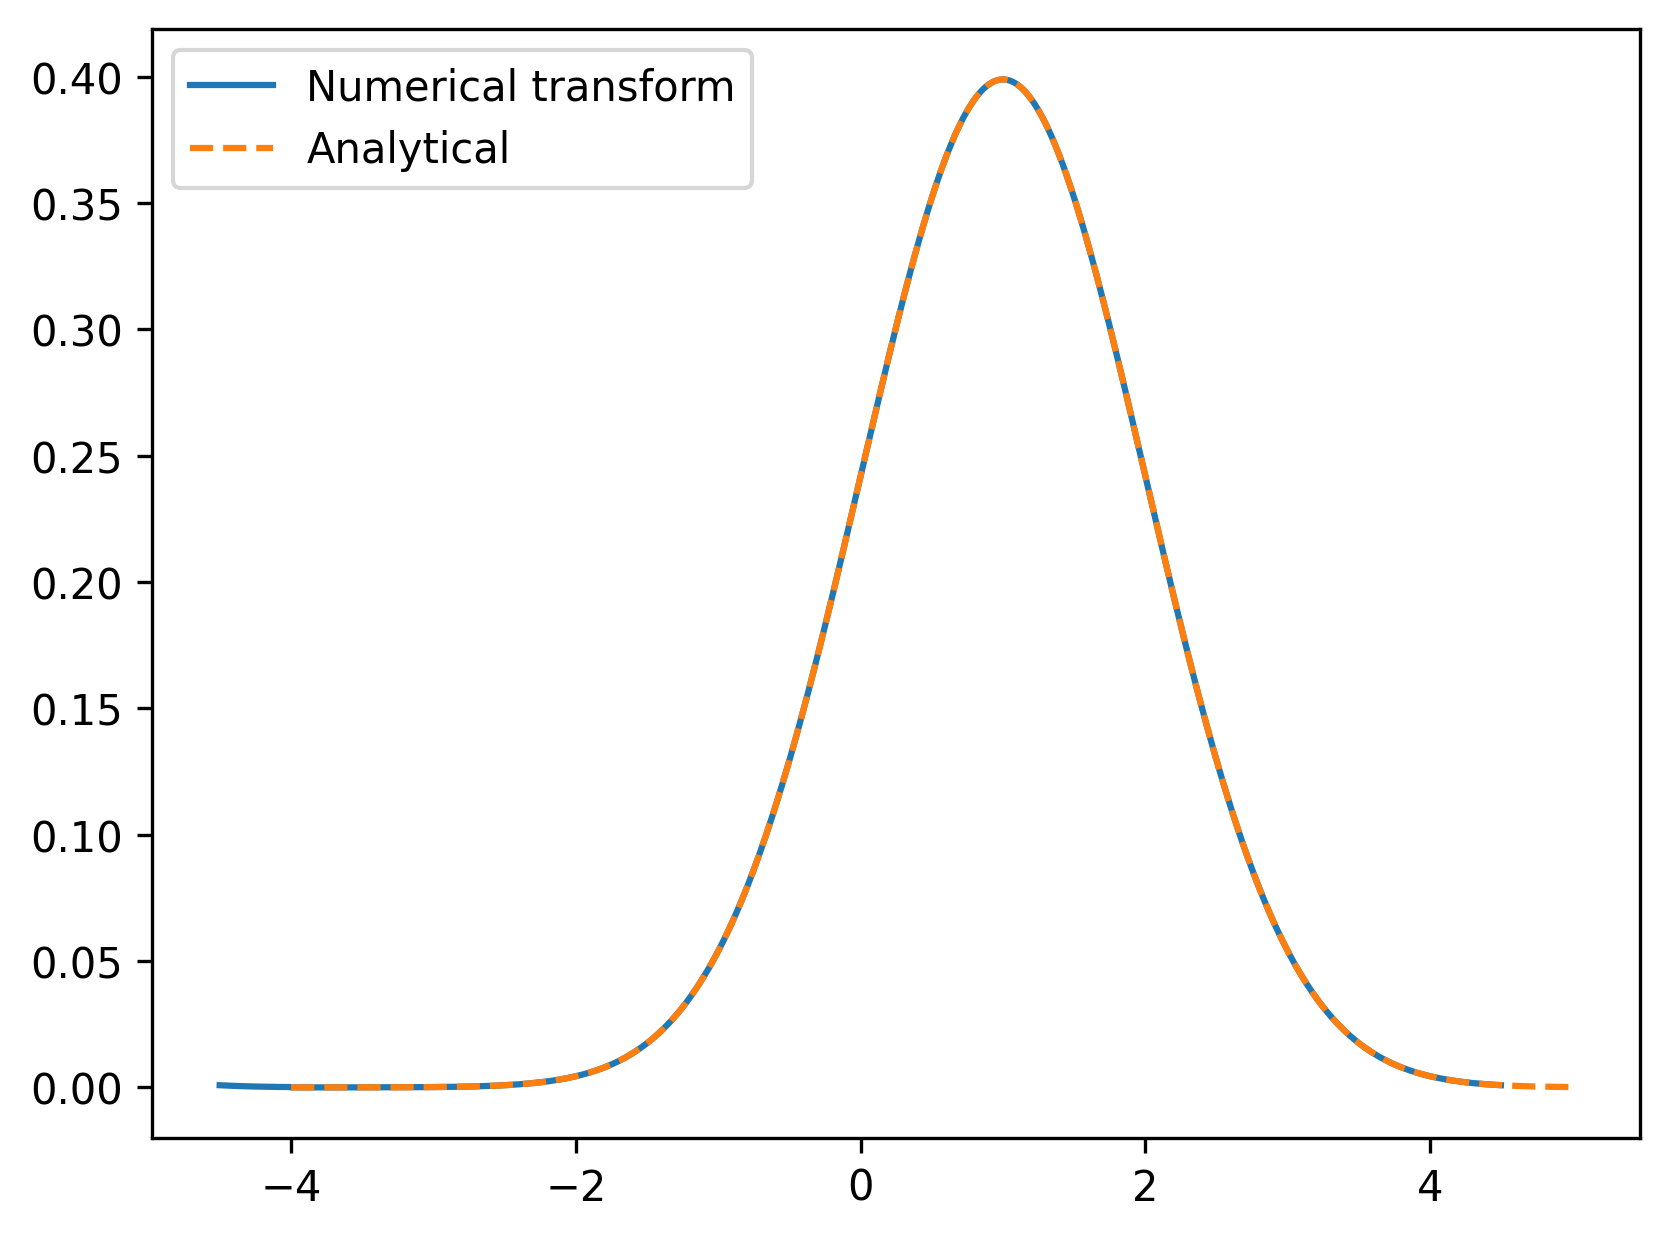

In [8]:
k, g = fourier_transform_1d(f, x)
y, h = inverse_fourier_transform_1d(g, k, sort_results=True)

plt.plot(y, np.real(h), label='Numerical transform')
plt.plot(x, f(x), linestyle='--', label='Analytical')
plt.legend();

# References

[1] https://stackoverflow.com/questions/24077913/discretized-continuous-fourier-transform-with-numpy

[2] https://numpy.org/doc/stable/reference/routines.fft.html